In [20]:
%load_ext autoreload
%autoreload 2

# get project dir
# import standard libs
from IPython.display import display
from IPython.core.debugger import set_trace as bp
from pathlib import PurePath, Path
import sys
import time
from collections import OrderedDict as od
import re
import os
import json

pp = PurePath(Path.cwd()).parts[:]
pdir = PurePath(*pp)
data_script_dir = pdir / 'src' / 'data'
bars_script_dir = pdir / 'src' / 'features'
sys.path.append(data_script_dir.as_posix())
sys.path.append(bars_script_dir.as_posix())
viz_dir = pdir / 'reports' / 'figures'
data_dir = pdir / 'data'

# import python scientific stack
import pandas as pd
pd.set_option('display.max_rows', 100)
from dask import dataframe as dd
from dask.diagnostics import ProgressBar
from multiprocessing import cpu_count
pbar = ProgressBar()
pbar.register()
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from numba import jit
import math

# import visual tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns

plt.style.use('seaborn-talk')
plt.style.use('bmh')
#plt.rcParams['font.family'] = 'DejaVu Sans Mono'
plt.rcParams['font.size'] = 9.5
plt.rcParams['font.weight'] = 'medium'
plt.rcParams['figure.figsize'] = 10,7
blue, green, red, purple, gold, teal = sns.color_palette('colorblind', 6)

# import util libs
# from tqdm import tqdm, tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
from utils import *
from bars import *
from labelling import *

RANDOM_STATE = 777

print()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



In [2]:
def read_bbg_ticks(fp):
    df = (pd.read_csv(infp)
            .assign(dates = lambda raw_df: pd.to_datetime(raw_df['Unnamed: 0']))
            .assign(volume = lambda raw_df: raw_df['size'])
            .assign(price = lambda raw_df: raw_df['value'])
            .drop(['Unnamed: 0','type','size','value'],axis = 1)
            #.set_index('dates')
         )
    return df

In [3]:
infp = PurePath(data_dir/'raw'/'12 HK Equity.csv')
df = read_bbg_ticks(infp)

In [4]:
cprint(df)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                     dates  volume  price
191886 2018-10-03 16:08:25    2000   39.0
191887 2018-10-03 16:08:25   10000   39.0
191888 2018-10-03 16:08:25    1000   39.0
191889 2018-10-03 16:08:25    1000   39.0
191890 2018-10-03 16:08:27       0   39.0
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191891 entries, 0 to 191890
Data columns (total 3 columns):
dates     191891 non-null datetime64[ns]
volume    191891 non-null int64
price     191891 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 4.4 MB
None
-------------------------------------------------------------------------------



In [5]:
n_ticks = df.shape[0]

In [6]:
volume_ratio = (df.volume.sum()/n_ticks).round()
print(volume_ratio)

2203.0


In [7]:
volume_M = volume_ratio

In [8]:
v_bar_df = volume_bar_df(df,'volume',volume_M)

In [9]:
cprint(v_bar_df)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                         dates  volume  price
191849 2018-10-03 16:08:25.004   15000   39.0
191851 2018-10-03 16:08:25.005   17000   39.0
191856 2018-10-03 16:08:25.006    3000   39.0
191872 2018-10-03 16:08:25.007    2000   39.0
191879 2018-10-03 16:08:25.008   10000   39.0
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 68235 entries, 1 to 191879
Data columns (total 3 columns):
dates     68235 non-null datetime64[ns]
volume    68235 non-null int64
price     68235 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 2.1 MB
None
-------------------------------------------------------------------------------



In [10]:
v_bar_df.set_index('dates', inplace=True)

In [11]:
cprint(v_bar_df)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                         volume  price
dates                                 
2018-10-03 16:08:25.004   15000   39.0
2018-10-03 16:08:25.005   17000   39.0
2018-10-03 16:08:25.006    3000   39.0
2018-10-03 16:08:25.007    2000   39.0
2018-10-03 16:08:25.008   10000   39.0
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 68235 entries, 2018-03-23 09:20:00 to 2018-10-03 16:08:25.008000
Data columns (total 2 columns):
volume    68235 non-null int64
price     68235 non-null float64
dtypes: float64(1), int64(1)
memory usage: 1.6 MB
None
-------------------------------------------------------------------------------



In [12]:
close = v_bar_df.price.copy()
dailyVol = getDailyVol(close)

In [13]:
cprint(dailyVol)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                         dailyVol
dates                            
2018-10-03 16:08:25.004  0.003088
2018-10-03 16:08:25.005  0.003058
2018-10-03 16:08:25.006  0.003029
2018-10-03 16:08:25.007  0.003000
2018-10-03 16:08:25.008  0.002971
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 67321 entries, 2018-03-26 09:20:00 to 2018-10-03 16:08:25.008000
Data columns (total 1 columns):
dailyVol    67320 non-null float64
dtypes: float64(1)
memory usage: 1.0 MB
None
-------------------------------------------------------------------------------



In [14]:
cprint(dailyVol.to_frame())

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                         dailyVol
dates                            
2018-10-03 16:08:25.004  0.003088
2018-10-03 16:08:25.005  0.003058
2018-10-03 16:08:25.006  0.003029
2018-10-03 16:08:25.007  0.003000
2018-10-03 16:08:25.008  0.002971
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 67321 entries, 2018-03-26 09:20:00 to 2018-10-03 16:08:25.008000
Data columns (total 1 columns):
dailyVol    67320 non-null float64
dtypes: float64(1)
memory usage: 1.0 MB
None
-------------------------------------------------------------------------------



In [15]:
threshold = 1.65*dailyVol.std()+ dailyVol.mean()
retClose = returns(close)
tEvents = getTEvents(retClose, h = threshold)

In [16]:
tEvents

DatetimeIndex([       '2018-03-23 09:31:00',        '2018-03-23 15:07:16',
                      '2018-03-23 15:08:00',        '2018-03-23 15:10:31',
                      '2018-03-26 09:20:00', '2018-03-26 09:20:00.001000',
                      '2018-03-27 09:20:00', '2018-03-27 09:20:00.001000',
                      '2018-03-29 09:30:01',        '2018-03-29 09:30:24',
               ...
                      '2018-10-02 09:30:04',        '2018-10-02 09:30:05',
                      '2018-10-02 09:30:07',        '2018-10-02 09:30:27',
                      '2018-10-02 09:30:36',        '2018-10-03 09:20:00',
               '2018-10-03 09:20:00.001000', '2018-10-03 09:30:01.001000',
                      '2018-10-03 09:30:03',        '2018-10-03 09:30:06'],
              dtype='datetime64[ns]', length=423, freq=None)

In [17]:
t1 = addVerticalBarrier(tEvents, close)

In [18]:
cprint(t1)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                                  dates
2018-10-02 09:30:04 2018-10-03 09:30:06
2018-10-02 09:30:05 2018-10-03 09:30:06
2018-10-02 09:30:07 2018-10-03 09:30:08
2018-10-02 09:30:27 2018-10-03 09:30:38
2018-10-02 09:30:36 2018-10-03 09:30:38
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 418 entries, 2018-03-23 09:31:00 to 2018-10-02 09:30:36
Data columns (total 1 columns):
dates    418 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 6.5 KB
None
-------------------------------------------------------------------------------



In [26]:
ptSl = [1,1]
target = dailyVol

# select minRet
minRet = 0.001
# Run in single-threaded mode on Windows
import platform

if platform.system() == 'Windows':
    cpus = 1
else:
    cpus = cpu_count() - 1

events = getEvents(close, tEvents, ptSl, target, minRet, 1, t1 = t1)




In [27]:
cprint(events)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                                         t1      trgt
2018-10-03 09:20:00.000 2018-10-03 09:30:01  0.001577
2018-10-03 09:20:00.001 2018-10-03 09:30:01  0.001585
2018-10-03 09:30:01.001 2018-10-03 09:30:03  0.002481
2018-10-03 09:30:03.000 2018-10-03 09:30:08  0.002572
2018-10-03 09:30:06.000 2018-10-03 09:31:36  0.002710
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 415 entries, 2018-03-27 09:20:00 to 2018-10-03 09:30:06
Data columns (total 2 columns):
t1      415 non-null datetime64[ns]
trgt    415 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 29.7 KB
None
-------------------------------------------------------------------------------



In [28]:
labels = getBins(events, close)

In [29]:
cprint(labels)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                              ret  bin
2018-10-03 09:20:00.000  0.003922  1.0
2018-10-03 09:20:00.001  0.003922  1.0
2018-10-03 09:30:01.001 -0.007732 -1.0
2018-10-03 09:30:03.000  0.003896  1.0
2018-10-03 09:30:06.000  0.003891  1.0
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 415 entries, 2018-03-27 09:20:00 to 2018-10-03 09:30:06
Data columns (total 2 columns):
ret    415 non-null float64
bin    415 non-null float64
dtypes: float64(2)
memory usage: 29.7 KB
None
-------------------------------------------------------------------------------



In [30]:
labels.bin.value_counts()

 1.0    206
-1.0    205
 0.0      4
Name: bin, dtype: int64

In [32]:
fast_window = 3
slow_window = 7

close_df = (pd.DataFrame()
            .assign(price = close)
            .assign(fast  = close.ewm(fast_window).mean())
            .assign(slow  = close.ewm(slow_window).mean()))
cprint(close_df)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                         price       fast       slow
dates                                               
2018-10-03 16:08:25.004   39.0  39.007017  39.021842
2018-10-03 16:08:25.005   39.0  39.005263  39.019112
2018-10-03 16:08:25.006   39.0  39.003947  39.016723
2018-10-03 16:08:25.007   39.0  39.002961  39.014633
2018-10-03 16:08:25.008   39.0  39.002220  39.012804
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 68235 entries, 2018-03-23 09:20:00 to 2018-10-03 16:08:25.008000
Data columns (total 3 columns):
price    68235 non-null float64
fast     68235 non-null float64
slow     68235 non-null float64
dtypes: float64(3)
memory usage: 2.1 MB
None
-------------------------------------------------------------------------------



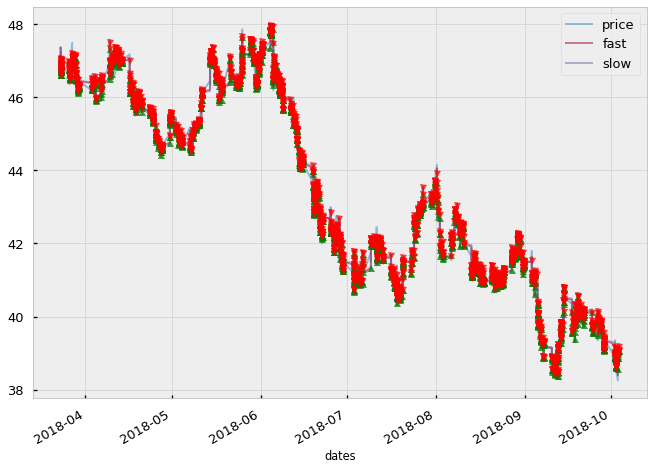

In [34]:
def get_up_cross(df):
    crit1 = df.fast.shift(1) < df.slow.shift(1)
    crit2 = df.fast > df.slow
    return df.fast[(crit1)&(crit2)]

def get_down_cross(df):
    crit1 = df.fast.shift(1) > df.slow.shift(1)
    crit2 = df.fast < df.slow
    return df.slow[(crit1) & (crit2)]

up = get_up_cross(close_df)
down = get_down_cross(close_df)

f, ax = plt.subplots(figsize=(11,8))

close_df.loc[:].plot(ax=ax,alpha=.5)
up.loc[:].plot(ax=ax,
                     ls='',
                     marker='^',
                     markersize=7,
                     alpha=.75,
                     label='upcross',
                     color = 'g')
down.loc[:].plot(ax=ax,
                     ls='',
                     marker='v',
                     markersize=7,
                     alpha=.75,
                     label='downcross',
                     color = 'r')


In [36]:
# trading signal
side_up = pd.Series(1,index = up.index)
side_down = pd.Series(-1, index = down.index)
side = pd.concat([side_up, side_down]).sort_index()
cprint(side)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                     0
dates                 
2018-10-03 14:50:55 -1
2018-10-03 15:47:40  1
2018-10-03 15:56:30 -1
2018-10-03 15:57:45  1
2018-10-03 15:58:01 -1
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5472 entries, 2018-03-23 09:37:34 to 2018-10-03 15:58:01
Data columns (total 1 columns):
0    5472 non-null int64
dtypes: int64(1)
memory usage: 85.5 KB
None
-------------------------------------------------------------------------------



In [38]:
minRet = .001
ptSl = [1,2]
ma_events = getEvents(close, tEvents, ptSl, target, minRet, cpus, t1 = t1, side = side)
cprint(ma_events)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                         side  t1      trgt
2018-10-03 09:20:00.000   NaN NaT  0.001577
2018-10-03 09:20:00.001   NaN NaT  0.001585
2018-10-03 09:30:01.001   NaN NaT  0.002481
2018-10-03 09:30:03.000   NaN NaT  0.002572
2018-10-03 09:30:06.000   NaN NaT  0.002710
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 415 entries, 2018-03-27 09:20:00 to 2018-10-03 09:30:06
Data columns (total 3 columns):
side    78 non-null float64
t1      410 non-null datetime64[ns]
trgt    415 non-null float64
dtypes: datetime64[ns](1), float64(2)
memory usage: 33.0 KB
None
-------------------------------------------------------------------------------



In [40]:
ma_events.side.value_counts()

 1.0    40
-1.0    38
Name: side, dtype: int64

In [41]:
ma_side= ma_events.dropna().side

In [42]:
ma_bins = getBins(ma_events,close).dropna()

In [43]:
cprint(ma_bins)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                              ret  bin
2018-09-26 15:59:41.000 -0.003769  0.0
2018-09-27 09:32:16.000  0.002513  1.0
2018-10-02 09:30:03.002 -0.007634  0.0
2018-10-02 09:30:07.000  0.003841  1.0
2018-10-02 09:30:27.000 -0.006369  0.0
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78 entries, 2018-03-27 09:20:00 to 2018-10-02 09:30:27
Data columns (total 2 columns):
ret    78 non-null float64
bin    78 non-null float64
dtypes: float64(2)
memory usage: 1.8 KB
None
-------------------------------------------------------------------------------



In [44]:
Xx = pd.merge_asof(ma_bins, side.to_frame().rename(columns = {0:'side'}),
                   left_index = True, right_index = True, direction = 'forward')

In [45]:
Xx.ret.sum()

-0.16352309031925172

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report

C:\Users\rex.wong\AppData\Local\Continuum\anaconda3\envs\rex\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [47]:
X = ma_side.values.reshape(-1,1)
y = ma_bins.bin.values
pd.DataFrame(X,y)

,0
0.0,1.0
0.0,-1.0
0.0,-1.0
0.0,-1.0
0.0,1.0
1.0,-1.0
0.0,-1.0
1.0,1.0
0.0,-1.0
0.0,1.0


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5, shuffle = False)

In [49]:
n_estimator = 777
rf = RandomForestClassifier(max_depth = 2, n_estimators=n_estimator,
                            criterion = 'entropy', random_state = RANDOM_STATE)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=777, n_jobs=1,
            oob_score=False, random_state=777, verbose=0, warm_start=False)

             precision    recall  f1-score   support

        0.0       0.51      1.00      0.68        20
        1.0       0.00      0.00      0.00        19

avg / total       0.26      0.51      0.35        39



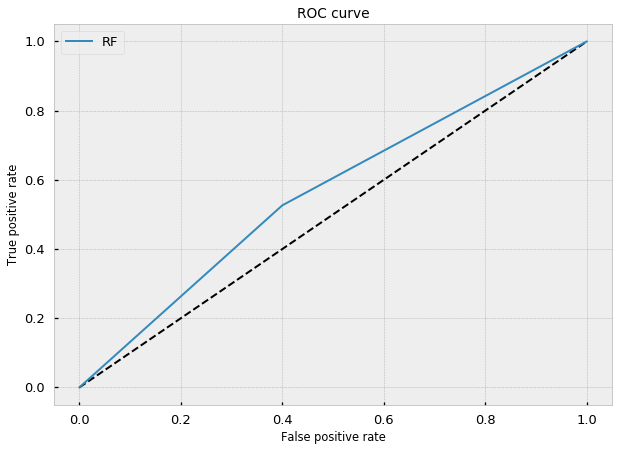

In [50]:
# The random forest model by itself

y_pred_rf = rf.predict_proba(X_test)[:,1]
y_pred = rf.predict(X_test)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))
      
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()